Como nuestra variable objetivo es un valor de 0-1, nuestro enfoque es de tipo regresion.

Se requiere construir un modelo de regresion que permita pronosticar la productividad  de cada empleado con un MAPE menor al 20%

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
data=pd.read_csv('garments_worker_productivity.csv')

In [3]:
data.head()

date   quarter  department       day  team  targeted_productivity  \
0  1/1/2015  Quarter1      sweing  Thursday     8                   0.80   
1  1/1/2015  Quarter1  finishing   Thursday     1                   0.75   
2  1/1/2015  Quarter1      sweing  Thursday    11                   0.80   
3  1/1/2015  Quarter1      sweing  Thursday    12                   0.80   
4  1/1/2015  Quarter1      sweing  Thursday     6                   0.80   

     smv     wip  over_time  incentive  idle_time  idle_men  \
0  26.16  1108.0       7080         98        0.0         0   
1   3.94     NaN        960          0        0.0         0   
2  11.41   968.0       3660         50        0.0         0   
3  11.41   968.0       3660         50        0.0         0   
4  25.90  1170.0       1920         50        0.0         0   

   no_of_style_change  no_of_workers  actual_productivity  
0                   0           59.0             0.940725  
1                   0            8.0             0.886500  
2                   0           30.5             0.800570  
3                   0           30.5             0.800570  
4                   0           56.0             0.800382

In [4]:
import matplotlib.pyplot as plt
import seaborn as sb
from ydata_profiling import ProfileReport


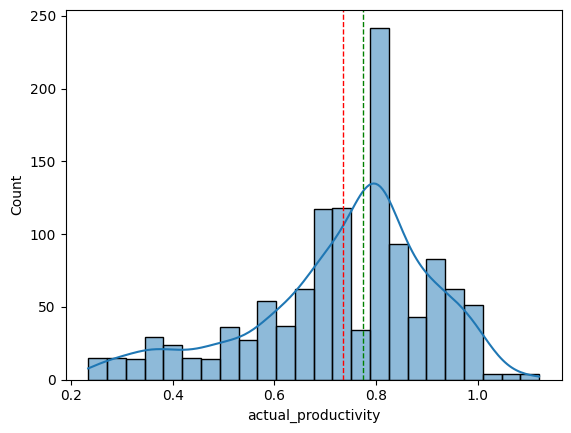

In [5]:
sb.histplot(data=data, x='actual_productivity', kde=True)
plt.axvline(data['actual_productivity'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(data['actual_productivity'].median(), color='green', linestyle='dashed', linewidth=1)
plt.show()

In [6]:
profile=ProfileReport (data)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Preparacion de datos
- Elimnar la vairbale idlemaen e idletime del conjunto
- Nulos de wip por 0
- Modificar finishing department
- Ajustar las varibales por tipo para modelo

In [7]:
data_mod=data.copy()    
data_mod=data.drop(['idle_time','idle_men'],axis=1)
data_mod['wip'].fillna(0, inplace=True)
data_mod['department'].replace({'finishing ':'finishing'},inplace=True)
data_mod['date']=pd.to_datetime(data_mod['date'],format='%m/%d/%Y')
data_mod['num_day']=[i.day for i in data_mod.date]
data_mod['month']=[i.month for i in data_mod.date]
data_mod['year']=[i.year for i in data_mod.date]
data_mod.drop(['date'],axis=1,inplace=True)
data_mod.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   quarter                1197 non-null   object 
 1   department             1197 non-null   object 
 2   day                    1197 non-null   object 
 3   team                   1197 non-null   int64  
 4   targeted_productivity  1197 non-null   float64
 5   smv                    1197 non-null   float64
 6   wip                    1197 non-null   float64
 7   over_time              1197 non-null   int64  
 8   incentive              1197 non-null   int64  
 9   no_of_style_change     1197 non-null   int64  
 10  no_of_workers          1197 non-null   float64
 11  actual_productivity    1197 non-null   float64
 12  num_day                1197 non-null   int64  
 13  month                  1197 non-null   int64  
 14  year                   1197 non-null   int64  
dtypes: f

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline

## En regresion es buena idea colocar en el endocer la variable objetivo

In [9]:
num_col=data_mod.select_dtypes(include=['float64', 'int64']).columns.to_list()
cat_col=data_mod.select_dtypes(include=['object']).columns.to_list()

num_transformer= Pipeline(steps=[('scaler', MinMaxScaler())])
cat_transformer= Pipeline(steps=[('encoder', OneHotEncoder())])

preprocessor= ColumnTransformer(transformers=[('num', num_transformer, num_col),
                                            ('cat', cat_transformer, cat_col)],
                                            remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['team', 'targeted_productivity', 'smv', 'wip',
                                  'over_time', 'incentive',
                                  'no_of_style_change', 'no_of_workers',
                                  'actual_productivity', 'num_day', 'month',
                                  'year']),
                                ('cat',
                                 Pipeline(steps=[('encoder', OneHotEncoder())]),
                                 ['quarter', 'department', 'day'])])

In [10]:
data_pre=preprocessor.fit_transform(data_mod)
cod_cat=preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(cat_col)
labels=np.concatenate([num_col,cod_cat])

data_pro=pd.DataFrame(data_pre, columns=labels)
data_pro.head()

team  targeted_productivity       smv       wip  over_time  incentive  \
0  0.636364               1.000000  0.450252  0.047920   0.273148   0.027222   
1  0.000000               0.931507  0.020132  0.000000   0.037037   0.000000   
2  0.909091               1.000000  0.164731  0.041865   0.141204   0.013889   
3  1.000000               1.000000  0.164731  0.041865   0.141204   0.013889   
4  0.454545               1.000000  0.445219  0.050601   0.074074   0.013889   

   no_of_style_change  no_of_workers  actual_productivity  num_day  ...  \
0                 0.0       0.655172             0.797332      0.0  ...   
1                 0.0       0.068966             0.736180      0.0  ...   
2                 0.0       0.327586             0.639274      0.0  ...   
3                 0.0       0.327586             0.639274      0.0  ...   
4                 0.0       0.620690             0.639062      0.0  ...   

   quarter_Quarter4  quarter_Quarter5  department_finishing  \
0               0.0               0.0                   0.0   
1               0.0               0.0                   1.0   
2               0.0               0.0                   0.0   
3               0.0               0.0                   0.0   
4               0.0               0.0                   0.0   

   department_sweing  day_Monday  day_Saturday  day_Sunday  day_Thursday  \
0                1.0         0.0           0.0         0.0           1.0   
1                0.0         0.0           0.0         0.0           1.0   
2                1.0         0.0           0.0         0.0           1.0   
3                1.0         0.0           0.0         0.0           1.0   
4                1.0         0.0           0.0         0.0           1.0   

   day_Tuesday  day_Wednesday  
0          0.0            0.0  
1          0.0            0.0  
2          0.0            0.0  
3          0.0            0.0  
4          0.0            0.0  

[5 rows x 25 columns]